# Importing libraries

In [193]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Cleaning and Preprocessing

In [2]:
#df_principals = pd.read_csv('data_principals.tsv', delimiter='\t')  ### kedze povodne sme to stahovali bez principals

#conn = sqlite3.connect('films.db')

#df_principals.to_sql('title_principals', conn, if_exists='replace', index=False) ##tak teraz to este extra pridavame

#conn.close()

In [194]:
# Connect to SQLite database
conn = sqlite3.connect('films.db')
# Querying the database
query = "SELECT * FROM title_ratings WHERE tconst IN (SELECT tb.tconst FROM title_basics AS tb WHERE tb.titleType = 'movie')"
df_title_ratings = pd.read_sql_query(query, conn)
df_title_ratings.replace("\\N", np.nan, inplace=True)

query = "SELECT nconst, primaryName FROM name_basics"
df_name_basics = pd.read_sql_query(query, conn)
df_name_basics.replace("\\N", np.nan, inplace=True)

query = "SELECT titleid, COUNT(CASE WHEN isOriginalTitle = 0 THEN 1 END) AS pocet_prekladov FROM title_akas GROUP BY titleid"
df_title_akas = pd.read_sql_query(query, conn)
df_title_akas.replace("\\N", np.nan, inplace=True)

query = "SELECT tconst, primaryTitle, isAdult, startYear, runtimeMinutes, genres  FROM title_basics WHERE titleType = 'movie'"
df_title_basics = pd.read_sql_query(query, conn)
df_title_basics.replace("\\N", np.nan, inplace=True)

#query = "SELECT * FROM title_crew"
#df_title_crew = pd.read_sql_query(query, conn)
#df_title_crew.replace("\\N", np.nan, inplace=True)

query = """SELECT tconst, nconst, category 
            FROM title_principals 
            WHERE (category = 'actor' OR category = 'director') 
            AND tconst IN (SELECT tb.tconst FROM title_basics AS tb WHERE tb.titleType = 'movie')"""
df_title_principals = pd.read_sql_query(query, conn)
# Close the connection
conn.close()

df_top_actors = pd.read_csv('top20actors.csv')

In [122]:
df_title_ratings.head()

,tconst,averageRating,numVotes,log_score
0,tt0000009,5.3,207,28.263410
1,tt0000147,5.3,489,32.819521
2,tt0000502,4.1,15,11.103006
3,tt0000574,6.0,862,40.555532
4,tt0000591,5.0,21,15.222612


In [123]:
df_title_akas.head()

,titleId,pocet_prekladov
0,tt0000001,7
1,tt0000002,7
2,tt0000003,8
3,tt0000004,7
4,tt0000005,11


In [124]:
df_title_basics['year_diff'] = df_title_basics['startYear']
df_title_basics['year_diff'] = df_title_basics['year_diff'].apply(lambda x: 2024 - int(x) if pd.notna(x) else np.nan)
df_title_basics.head()

,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres,year_diff
0,tt0000009,Miss Jerry,0,1894,45,Romance,130.0
1,tt0000147,The Corbett-Fitzsimmons Fight,0,1897,100,"Documentary,News,Sport",127.0
2,tt0000502,Bohemios,0,1905,100,NaN,119.0
3,tt0000574,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography",118.0
4,tt0000591,The Prodigal Son,0,1907,90,Drama,117.0


In [125]:
df_title_crew.head()

NameError: name 'df_title_crew' is not defined

In [129]:
df_title_ratings['log_score'] = df_title_ratings['averageRating'] * np.log(df_title_ratings['numVotes'])
df_title_ratings['norm_score'] = (df_title_ratings['averageRating'] / max(df_title_ratings['averageRating'])) * (df_title_ratings['numVotes'] / max(df_title_ratings['numVotes']))
df_title_ratings['prag_score'] = (df_title_ratings['averageRating'] * df_title_ratings['numVotes']) / (np.mean(df_title_ratings['averageRating']) * np.mean(df_title_ratings['numVotes'])) 

In [130]:
df_title_ratings.describe()

,averageRating,numVotes,log_score,norm_score,prag_score
count,301868.000000,3.018680e+05,301868.000000,3.018680e+05,301868.000000
mean,6.175532,3.627837e+03,28.023937,8.984794e-04,1.136912
std,1.373577,3.584098e+04,14.541876,1.000128e-02,12.655354
min,1.000000,5.000000e+00,1.791759,2.116462e-07,0.000268
25%,5.300000,1.900000e+01,17.891328,4.137683e-06,0.005236
50%,6.300000,6.100000e+01,24.609682,1.314323e-05,0.016631
75%,7.100000,3.150000e+02,34.169375,6.213667e-05,0.078626
max,10.000000,2.834920e+06,138.174976,9.300000e-01,1176.797173


In [131]:
df = df_title_ratings[df_title_ratings['log_score'] > 130]
df.sort_values(by=['log_score'])

,tconst,averageRating,numVotes,log_score,norm_score,prag_score
78432,tt0167260,9.0,1941303,130.309830,0.616304,779.854702
36429,tt0068646,9.2,1975771,133.367517,0.641185,811.338891
136130,tt0468569,9.0,2816224,133.658168,0.894065,1131.325470
61218,tt0111161,9.3,2834920,138.174976,0.930000,1176.797173


In [132]:
df_title_ratings = df_title_ratings.drop('norm_score', axis=1)
df_title_ratings = df_title_ratings.drop('prag_score', axis=1)

In [133]:
df_films = df_title_ratings.set_index('tconst').join(df_title_akas.set_index('titleId'), how='inner')
df_films = df_films.join(df_title_basics.set_index('tconst'), how='inner')

df_films['startYear'] = df_films['startYear'].apply(lambda x: int(x) if pd.notna(x) else np.nan)
df_films['runtimeMinutes'] = df_films['runtimeMinutes'].apply(lambda x: int(x) if pd.notna(x) else np.nan)
df_films['isAdult'] = df_films['isAdult'].apply(lambda x: int(x) if pd.notna(x) else np.nan)

df_films.head()

,averageRating,numVotes,log_score,pocet_prekladov,primaryTitle,isAdult,startYear,runtimeMinutes,genres,year_diff
tt0000009,5.3,207,28.263410,4,Miss Jerry,0,1894.0,45.0,Romance,130.0
tt0000147,5.3,489,32.819521,2,The Corbett-Fitzsimmons Fight,0,1897.0,100.0,"Documentary,News,Sport",127.0
tt0000502,4.1,15,11.103006,1,Bohemios,0,1905.0,100.0,NaN,119.0
tt0000574,6.0,862,40.555532,8,The Story of the Kelly Gang,0,1906.0,70.0,"Action,Adventure,Biography",118.0
tt0000591,5.0,21,15.222612,2,The Prodigal Son,0,1907.0,90.0,Drama,117.0


In [134]:
df_films.describe()

,averageRating,numVotes,log_score,pocet_prekladov,isAdult,startYear,runtimeMinutes,year_diff
count,300814.000000,3.008140e+05,300814.000000,300814.000000,300814.000000,300777.000000,271352.000000,300777.000000
mean,6.174886,3.637721e+03,28.047625,6.659291,0.015461,1995.173404,94.472508,28.826596
std,1.372649,3.590068e+04,14.545924,9.361295,0.123379,25.895465,137.517464,25.895465
min,1.000000,5.000000e+00,1.791759,1.000000,0.000000,1894.000000,1.000000,1.000000
25%,5.300000,1.900000e+01,17.919531,1.000000,0.000000,1979.000000,81.000000,8.000000
50%,6.300000,6.200000e+01,24.642296,3.000000,0.000000,2005.000000,91.000000,19.000000
75%,7.100000,3.160000e+02,34.204877,7.000000,0.000000,2016.000000,103.000000,45.000000
max,10.000000,2.834920e+06,138.174976,249.000000,1.000000,2023.000000,51420.000000,130.000000


In [135]:
df_genre_log = df_films.loc[:, ['primaryTitle', 'log_score', 'genres']]
df_genre_log['genres'] = df_genre_log['genres'].str.split(',')
df_genre_log['genres'] = df_genre_log['genres'].apply(lambda x: ",".join(sorted(x)) if isinstance(x, list) else np.nan)
df_genre_log.head()

,primaryTitle,log_score,genres
tt0000009,Miss Jerry,28.263410,Romance
tt0000147,The Corbett-Fitzsimmons Fight,32.819521,"Documentary,News,Sport"
tt0000502,Bohemios,11.103006,NaN
tt0000574,The Story of the Kelly Gang,40.555532,"Action,Adventure,Biography"
tt0000591,The Prodigal Son,15.222612,Drama


In [136]:
df_genre_log['genres'].value_counts()

Drama                         51002
Documentary                   31616
Comedy                        24670
Comedy,Drama                   9712
Drama,Romance                  9262
                              ...  
Biography,Comedy,Mystery          1
Adult,Drama,War                   1
Family,Romance,Sci-Fi             1
Adult,Adventure,Horror            1
Action,Documentary,Mystery        1
Name: genres, Length: 1274, dtype: int64

In [137]:
# Filter rows where 'genres' contains a comma
df_genre_combinations = df_genre_log[df_genre_log['genres'].str.contains(",", na=False)]
df_genre_count = df_genre_combinations['genres'].value_counts()
df_genre_combinations = list(df_genre_count[df_genre_count >= 1000].index)

In [138]:
df_filtered_genres = df_genre_log[df_genre_log['genres'].isin(df_genre_combinations)]
df_filtered_genres

,primaryTitle,log_score,genres
tt0001049,Gøngehøvdingen,12.139561,"Drama,War"
tt0001175,Camille,20.056205,"Drama,Romance"
tt0001370,Rainha Depois de Morta Inês de Castro,17.060042,"Drama,History"
tt0001440,Valdemar Sejr,14.527900,"Drama,History"
tt0001475,Amor fatal,23.202657,"Drama,Romance"
...,...,...,...
tt9911196,The Marriage Escape,60.557533,"Comedy,Drama"
tt9911306,Kalikkoottukar,11.758799,"Drama,Romance"
tt9913936,Paradise,30.540794,"Crime,Drama"
tt9914286,Sokagin Çocuklari,20.461081,"Drama,Family"


In [139]:
df_one_hot = pd.get_dummies(df_filtered_genres, columns=['genres'])
df_first_part = df_one_hot.iloc[:, :2].reset_index() 
df_second_part = df_one_hot.iloc[:, 2:].reset_index()   

df_first_grouped = df_first_part.groupby('index', as_index=False).first()

df_second_grouped = df_second_part.groupby('index', as_index=False).sum()

df_filtered_genres = pd.concat([df_first_grouped, df_second_grouped], axis=1)

df_filtered_genres = df_filtered_genres.loc[:,~df_filtered_genres.columns.duplicated()]
df_filtered_genres = df_filtered_genres.set_index('index')

df_filtered_genres.head()

,primaryTitle,log_score,"genres_Action,Adventure,Comedy","genres_Action,Adventure,Drama","genres_Action,Comedy","genres_Action,Comedy,Crime","genres_Action,Crime,Drama","genres_Action,Drama","genres_Action,Thriller","genres_Biography,Documentary",...,"genres_Documentary,History","genres_Documentary,Music","genres_Drama,Family","genres_Drama,History","genres_Drama,Romance","genres_Drama,Thriller","genres_Drama,War","genres_Drama,Western","genres_Horror,Mystery,Thriller","genres_Horror,Thriller"
index,,,,,,,,,,,,,,,,,,,,,
tt0001049,Gøngehøvdingen,12.139561,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
tt0001175,Camille,20.056205,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
tt0001370,Rainha Depois de Morta Inês de Castro,17.060042,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
tt0001440,Valdemar Sejr,14.527900,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
tt0001475,Amor fatal,23.202657,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [140]:
# Split and explode the 'genres' column
df_films['genres'] = df_films['genres'].str.split(',')
df_exploded = df_films.explode('genres')

df_one_hot = pd.get_dummies(df_exploded, columns=['genres'])
# Split the DataFrame into two parts
df_first_part = df_one_hot.iloc[:, :9].reset_index()  # First 9 columns
df_second_part = df_one_hot.iloc[:, 9:].reset_index()   # Rest of the columns

# Apply groupby and first on the first part
df_first_grouped = df_first_part.groupby('index', as_index=False).first()

# Apply groupby and sum on the second part
df_second_grouped = df_second_part.groupby('index', as_index=False).sum()

# Concatenate the two DataFrames along the columns axis
df_films = pd.concat([df_first_grouped, df_second_grouped], axis=1)

# Dropping duplicate columns (as 'index' will be duplicated)
df_films = df_films.loc[:,~df_films.columns.duplicated()]
df_films = df_films.set_index('index')

df_films.head()

,averageRating,numVotes,log_score,pocet_prekladov,primaryTitle,isAdult,startYear,runtimeMinutes,year_diff,genres_Action,...,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western
index,,,,,,,,,,,,,,,,,,,,,
tt0000009,5.3,207,28.263410,4,Miss Jerry,0,1894.0,45.0,130.0,0,...,0,0,0,1,0,0,0,0,0,0
tt0000147,5.3,489,32.819521,2,The Corbett-Fitzsimmons Fight,0,1897.0,100.0,127.0,0,...,0,1,0,0,0,1,0,0,0,0
tt0000502,4.1,15,11.103006,1,Bohemios,0,1905.0,100.0,119.0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000574,6.0,862,40.555532,8,The Story of the Kelly Gang,0,1906.0,70.0,118.0,1,...,0,0,0,0,0,0,0,0,0,0
tt0000591,5.0,21,15.222612,2,The Prodigal Son,0,1907.0,90.0,117.0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
df_top_actors['nconst']
df_films_with_top_actors = df_title_principals[df_title_principals['nconst'].isin(df_top_actors['nconst'])]
df_films_with_top_actors['category'].value_counts()
df_sorted_by_tconst = df_films_with_top_actors[df_films_with_top_actors['nconst'] == 'nm0000576'].sort_values(by='tconst', ascending=True)
df_sorted_by_tconst

,tconst,nconst,category
222538,tt0083169,nm0000576,actor
224172,tt0083929,nm0000576,actor
227062,tt0085210,nm0000576,actor
231496,tt0087096,nm0000576,actor
231839,tt0087231,nm0000576,actor
233633,tt0087968,nm0000576,actor
239439,tt0090670,nm0000576,actor
242596,tt0091934,nm0000576,actor
249077,tt0094894,nm0000576,actor
253697,tt0097027,nm0000576,actor


# Exploratory Data Analysis (EDA)

In [141]:
df_films.describe()

,averageRating,numVotes,log_score,pocet_prekladov,isAdult,startYear,runtimeMinutes,year_diff,genres_Action,genres_Adult,...,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western
count,300814.000000,3.008140e+05,300814.000000,300814.000000,300814.000000,300777.000000,271352.000000,300777.000000,300814.000000,300814.000000,...,300814.000000,300814.000000,300814.000000,300814.000000,300814.000000,300814.00000,300814.000000,300814.000000,300814.000000,300814.000000
mean,6.174886,3.637721e+03,28.047625,6.659291,0.015461,1995.173404,94.472508,28.826596,0.103469,0.014541,...,0.039406,0.002224,0.000206,0.111644,0.023682,0.01237,0.000050,0.083799,0.020744,0.017153
std,1.372649,3.590068e+04,14.545924,9.361295,0.123379,25.895465,137.517464,25.895465,0.304571,0.119704,...,0.194560,0.047107,0.014355,0.314928,0.152058,0.11053,0.007061,0.277087,0.142525,0.129843
min,1.000000,5.000000e+00,1.791759,1.000000,0.000000,1894.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,5.300000,1.900000e+01,17.919531,1.000000,0.000000,1979.000000,81.000000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,6.300000,6.200000e+01,24.642296,3.000000,0.000000,2005.000000,91.000000,19.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,7.100000,3.160000e+02,34.204877,7.000000,0.000000,2016.000000,103.000000,45.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,10.000000,2.834920e+06,138.174976,249.000000,1.000000,2023.000000,51420.000000,130.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [142]:
print(df_films.iloc[:, 9:].columns.tolist())

['genres_Action', 'genres_Adult', 'genres_Adventure', 'genres_Animation', 'genres_Biography', 'genres_Comedy', 'genres_Crime', 'genres_Documentary', 'genres_Drama', 'genres_Family', 'genres_Fantasy', 'genres_Film-Noir', 'genres_Game-Show', 'genres_History', 'genres_Horror', 'genres_Music', 'genres_Musical', 'genres_Mystery', 'genres_News', 'genres_Reality-TV', 'genres_Romance', 'genres_Sci-Fi', 'genres_Sport', 'genres_Talk-Show', 'genres_Thriller', 'genres_War', 'genres_Western']


In [143]:
# Basic data exploration
print(df_films.shape)
print(df_films.dtypes)

(300814, 36)
averageRating         float64
numVotes                int64
log_score             float64
pocet_prekladov         int64
primaryTitle           object
isAdult                 int64
startYear             float64
runtimeMinutes        float64
year_diff             float64
genres_Action           uint8
genres_Adult            uint8
genres_Adventure        uint8
genres_Animation        uint8
genres_Biography        uint8
genres_Comedy           uint8
genres_Crime            uint8
genres_Documentary      uint8
genres_Drama            uint8
genres_Family           uint8
genres_Fantasy          uint8
genres_Film-Noir        uint8
genres_Game-Show        uint8
genres_History          uint8
genres_Horror           uint8
genres_Music            uint8
genres_Musical          uint8
genres_Mystery          uint8
genres_News             uint8
genres_Reality-TV       uint8
genres_Romance          uint8
genres_Sci-Fi           uint8
genres_Sport            uint8
genres_Talk-Show        uin

In [144]:
df_films.isna().sum()

averageRating             0
numVotes                  0
log_score                 0
pocet_prekladov           0
primaryTitle              0
isAdult                   0
startYear                37
runtimeMinutes        29462
year_diff                37
genres_Action             0
genres_Adult              0
genres_Adventure          0
genres_Animation          0
genres_Biography          0
genres_Comedy             0
genres_Crime              0
genres_Documentary        0
genres_Drama              0
genres_Family             0
genres_Fantasy            0
genres_Film-Noir          0
genres_Game-Show          0
genres_History            0
genres_Horror             0
genres_Music              0
genres_Musical            0
genres_Mystery            0
genres_News               0
genres_Reality-TV         0
genres_Romance            0
genres_Sci-Fi             0
genres_Sport              0
genres_Talk-Show          0
genres_Thriller           0
genres_War                0
genres_Western      

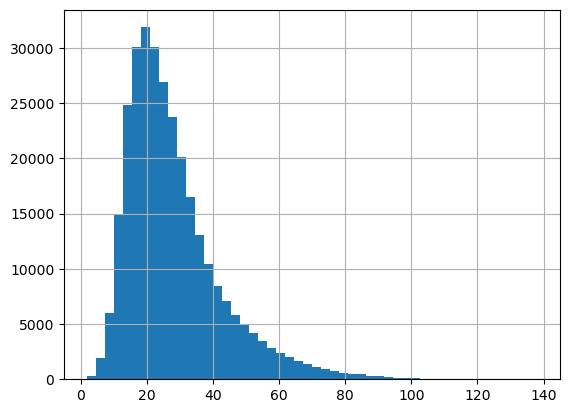

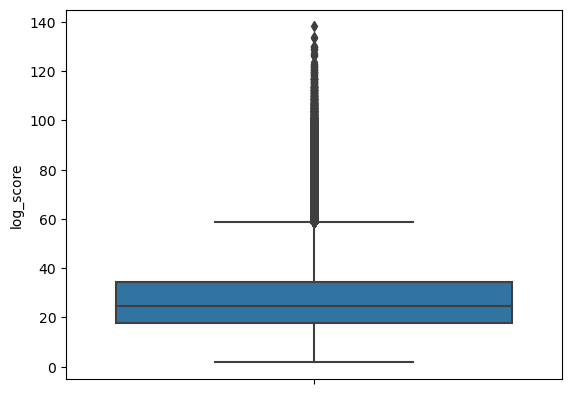

In [145]:
# Univariate Analysis
df_films['log_score'].hist(bins = 50)
plt.show()

sns.boxplot(y='log_score', data=df_films)
plt.show()

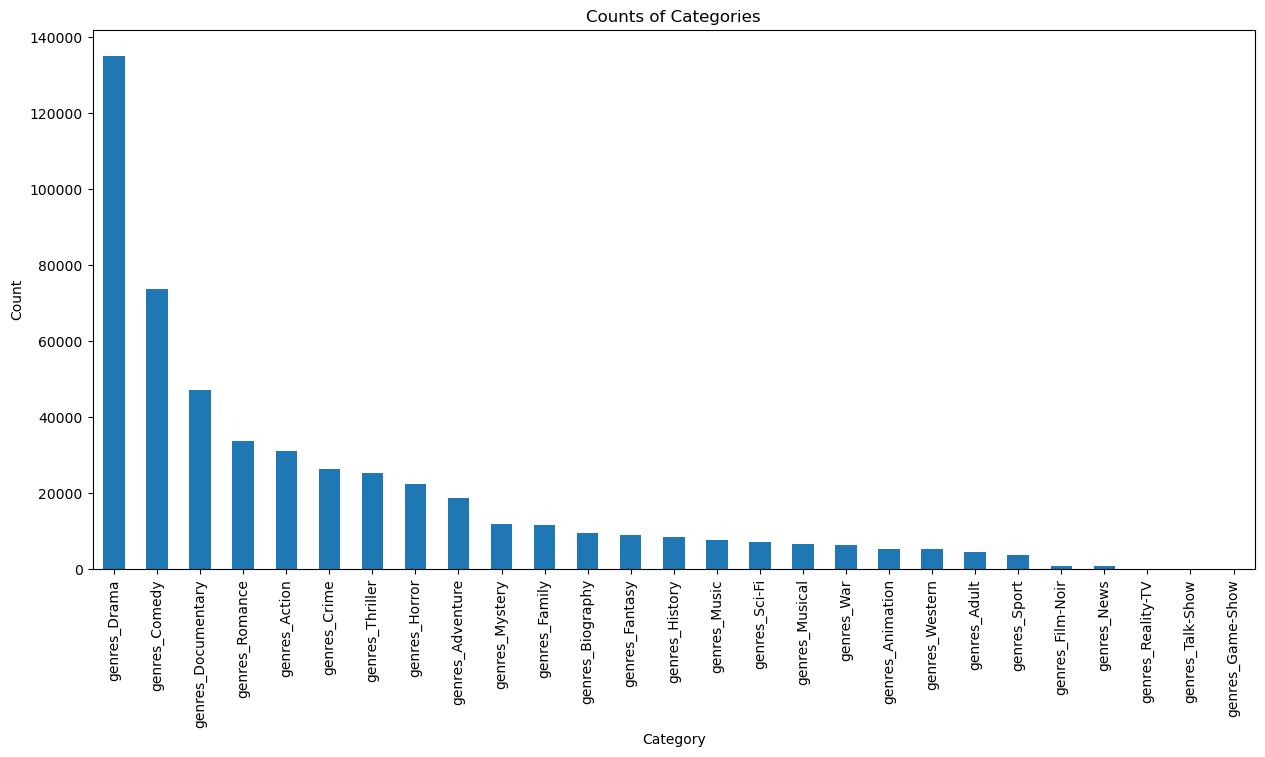

In [156]:
categorical_columns = ['genres_Action', 'genres_Adult', 'genres_Adventure', 'genres_Animation', 'genres_Biography', 
                       'genres_Comedy', 'genres_Crime', 'genres_Documentary', 'genres_Drama', 'genres_Family', 
                       'genres_Fantasy', 'genres_Film-Noir', 'genres_Game-Show', 'genres_History', 'genres_Horror', 
                       'genres_Music', 'genres_Musical', 'genres_Mystery', 'genres_News', 'genres_Reality-TV', 
                       'genres_Romance', 'genres_Sci-Fi', 'genres_Sport', 'genres_Talk-Show', 'genres_Thriller', 
                       'genres_War', 'genres_Western']

category_counts = df_films[categorical_columns].sum()

# Sort the counts for better visualization, if desired
category_counts_sorted = category_counts.sort_values(ascending=False)

# Plot the counts in a single bar plot
category_counts_sorted.plot(kind='bar', figsize=(15, 7))  # You can adjust the figure size as needed
plt.title('Counts of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

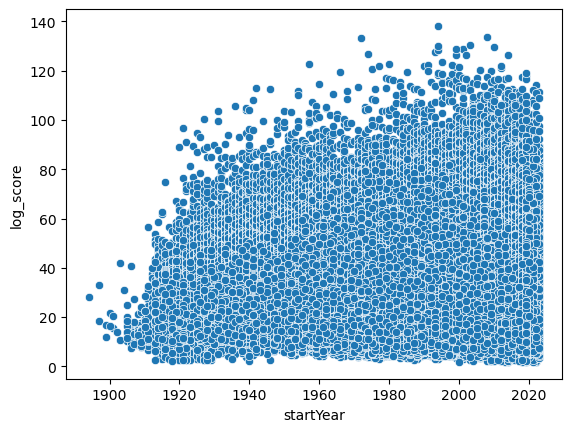

In [157]:
# Bivariate Analysis
sns.scatterplot(x='startYear', y='log_score', data=df_films)
plt.show()

In [158]:
df_films.describe()

,averageRating,numVotes,log_score,pocet_prekladov,isAdult,startYear,runtimeMinutes,year_diff,genres_Action,genres_Adult,...,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western
count,300814.000000,3.008140e+05,300814.000000,300814.000000,300814.000000,300777.000000,271352.000000,300777.000000,300814.000000,300814.000000,...,300814.000000,300814.000000,300814.000000,300814.000000,300814.000000,300814.00000,300814.000000,300814.000000,300814.000000,300814.000000
mean,6.174886,3.637721e+03,28.047625,6.659291,0.015461,1995.173404,94.472508,28.826596,0.103469,0.014541,...,0.039406,0.002224,0.000206,0.111644,0.023682,0.01237,0.000050,0.083799,0.020744,0.017153
std,1.372649,3.590068e+04,14.545924,9.361295,0.123379,25.895465,137.517464,25.895465,0.304571,0.119704,...,0.194560,0.047107,0.014355,0.314928,0.152058,0.11053,0.007061,0.277087,0.142525,0.129843
min,1.000000,5.000000e+00,1.791759,1.000000,0.000000,1894.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,5.300000,1.900000e+01,17.919531,1.000000,0.000000,1979.000000,81.000000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,6.300000,6.200000e+01,24.642296,3.000000,0.000000,2005.000000,91.000000,19.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,7.100000,3.160000e+02,34.204877,7.000000,0.000000,2016.000000,103.000000,45.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,10.000000,2.834920e+06,138.174976,249.000000,1.000000,2023.000000,51420.000000,130.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [178]:
columns = list(categorical_columns)
columns = ['averageRating', 'numVotes', 'log_score'] + columns
#columns.insert(0, 'log_score')
df_film_genres = df_films.loc[:, columns]
df_film_genres.head()

,averageRating,numVotes,log_score,genres_Action,genres_Adult,genres_Adventure,genres_Animation,genres_Biography,genres_Comedy,genres_Crime,...,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western
index,,,,,,,,,,,,,,,,,,,,,
tt0000009,5.3,207,28.263410,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
tt0000147,5.3,489,32.819521,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
tt0000502,4.1,15,11.103006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000574,6.0,862,40.555532,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000591,5.0,21,15.222612,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
corr_matrix = df_film_genres.corr(numeric_only = True)
corr_matrix

,averageRating,numVotes,log_score,genres_Action,genres_Adult,genres_Adventure,genres_Animation,genres_Biography,genres_Comedy,genres_Crime,...,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western
averageRating,1.000000,0.062484,0.331690,-0.110328,-0.055481,-0.057662,0.018680,0.102287,-0.110806,-0.042899,...,-0.047497,0.035762,0.005071,-0.018545,-0.094162,0.037079,0.004554,-0.124795,0.024595,-0.032337
numVotes,0.062484,1.000000,0.384120,0.076666,-0.012083,0.083812,0.032255,0.020059,0.013044,0.037706,...,0.034860,-0.004315,-0.001411,0.003192,0.067548,0.003472,-0.000707,0.031138,0.001115,-0.005842
log_score,0.331690,0.384120,1.000000,0.069023,-0.072736,0.067495,0.065744,0.090937,0.084672,0.114939,...,0.079509,-0.004023,-0.005493,0.097059,0.032160,0.043264,-0.003396,0.059451,0.035817,-0.000534
genres_Action,-0.110328,0.076666,0.069023,1.000000,-0.037984,0.203527,0.045844,-0.039251,-0.052003,0.171138,...,-0.030435,-0.015575,-0.004117,-0.063490,0.065168,-0.011752,-0.002399,0.057895,0.000027,-0.016804
genres_Adult,-0.055481,-0.012083,-0.072736,-0.037984,1.000000,-0.027224,-0.013525,-0.020505,-0.020457,-0.018695,...,-0.018322,-0.005735,-0.001744,-0.026572,-0.011065,-0.011333,0.007008,-0.030522,-0.017290,-0.011770
genres_Adventure,-0.057662,0.083812,0.067495,0.203527,-0.027224,1.000000,0.174021,-0.015054,-0.004842,-0.008762,...,-0.021047,-0.006534,-0.001757,-0.041814,0.029571,-0.015448,-0.001811,-0.048333,-0.006204,0.004856
genres_Animation,0.018680,0.032255,0.065744,0.045844,-0.013525,0.174021,1.000000,-0.005664,0.008333,-0.031831,...,-0.022094,-0.004083,-0.001901,-0.042077,0.018350,-0.006269,-0.000935,-0.037836,-0.015689,-0.016510
genres_Biography,0.102287,0.020059,0.090937,-0.039251,-0.020505,-0.015054,-0.005664,1.000000,-0.076228,-0.019477,...,-0.033176,0.013466,0.002757,-0.047536,-0.026798,0.048479,-0.001266,-0.050784,-0.001535,-0.019418
genres_Comedy,-0.110806,0.013044,0.084672,-0.052003,-0.020457,-0.004842,0.008333,-0.076228,1.000000,-0.045136,...,-0.066945,-0.024948,-0.006033,0.110910,-0.024721,-0.019137,-0.004026,-0.134721,-0.061076,-0.047708
genres_Crime,-0.042899,0.037706,0.114939,0.171138,-0.018695,-0.008762,-0.031831,-0.019477,-0.045136,1.000000,...,0.111822,-0.010073,-0.002791,-0.059486,-0.034834,-0.027305,-0.000511,0.112538,-0.040477,-0.035165


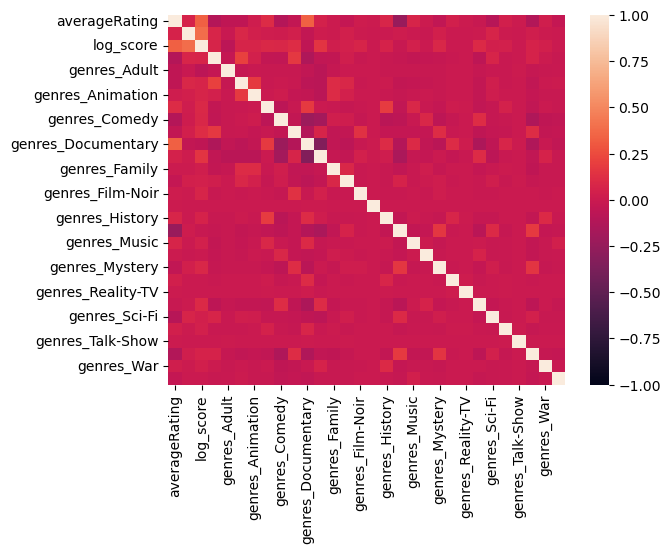

In [180]:
sns.heatmap(corr_matrix, vmin=-1, vmax=1)
plt.show()

In [173]:
corr_matrix = df_filtered_genres.corr(numeric_only = True)
corr_matrix

,log_score,"genres_Action,Adventure,Comedy","genres_Action,Adventure,Drama","genres_Action,Comedy","genres_Action,Comedy,Crime","genres_Action,Crime,Drama","genres_Action,Drama","genres_Action,Thriller","genres_Biography,Documentary","genres_Comedy,Crime",...,"genres_Documentary,History","genres_Documentary,Music","genres_Drama,Family","genres_Drama,History","genres_Drama,Romance","genres_Drama,Thriller","genres_Drama,War","genres_Drama,Western","genres_Horror,Mystery,Thriller","genres_Horror,Thriller"
log_score,1.000000,0.029548,0.018983,-0.032096,0.053701,0.033416,-0.065671,-0.007111,-0.025921,0.001759,...,-0.022665,-0.007005,-0.042841,-0.007089,-0.010588,-0.010980,-0.006557,-0.008986,0.015505,-0.056341
"genres_Action,Adventure,Comedy",0.029548,1.000000,-0.017660,-0.016019,-0.015586,-0.026842,-0.024612,-0.016062,-0.019819,-0.016574,...,-0.015681,-0.020906,-0.020156,-0.016154,-0.048482,-0.026806,-0.021686,-0.015630,-0.015912,-0.023531
"genres_Action,Adventure,Drama",0.018983,-0.017660,1.000000,-0.017621,-0.017144,-0.029526,-0.027073,-0.017668,-0.021800,-0.018231,...,-0.017248,-0.022996,-0.022171,-0.017769,-0.053328,-0.029486,-0.023854,-0.017192,-0.017503,-0.025884
"genres_Action,Comedy",-0.032096,-0.016019,-0.017621,1.000000,-0.015551,-0.026783,-0.024558,-0.016026,-0.019775,-0.016537,...,-0.015646,-0.020859,-0.020112,-0.016118,-0.048374,-0.026747,-0.021638,-0.015595,-0.015877,-0.023479
"genres_Action,Comedy,Crime",0.053701,-0.015586,-0.017144,-0.015551,1.000000,-0.026058,-0.023893,-0.015593,-0.019240,-0.016090,...,-0.015223,-0.020295,-0.019567,-0.015682,-0.047065,-0.026023,-0.021053,-0.015173,-0.015447,-0.022844
"genres_Action,Crime,Drama",0.033416,-0.026842,-0.029526,-0.026783,-0.026058,1.000000,-0.041150,-0.026854,-0.033135,-0.027710,...,-0.026217,-0.034952,-0.033699,-0.027008,-0.081057,-0.044817,-0.036257,-0.026131,-0.026603,-0.039342
"genres_Action,Drama",-0.065671,-0.024612,-0.027073,-0.024558,-0.023893,-0.041150,1.000000,-0.024623,-0.030383,-0.025408,...,-0.024039,-0.032049,-0.030900,-0.024765,-0.074323,-0.041094,-0.033245,-0.023961,-0.024393,-0.036074
"genres_Action,Thriller",-0.007111,-0.016062,-0.017668,-0.016026,-0.015593,-0.026854,-0.024623,1.000000,-0.019828,-0.016581,...,-0.015688,-0.020915,-0.020165,-0.016161,-0.048503,-0.026818,-0.021696,-0.015637,-0.015919,-0.023542
"genres_Biography,Documentary",-0.025921,-0.019819,-0.021800,-0.019775,-0.019240,-0.033135,-0.030383,-0.019828,1.000000,-0.020459,...,-0.019357,-0.025807,-0.024882,-0.019942,-0.059848,-0.033091,-0.026770,-0.019294,-0.019642,-0.029048
"genres_Comedy,Crime",0.001759,-0.016574,-0.018231,-0.016537,-0.016090,-0.027710,-0.025408,-0.016581,-0.020459,1.000000,...,-0.016187,-0.021581,-0.020808,-0.016676,-0.050048,-0.027672,-0.022387,-0.016135,-0.016426,-0.024292


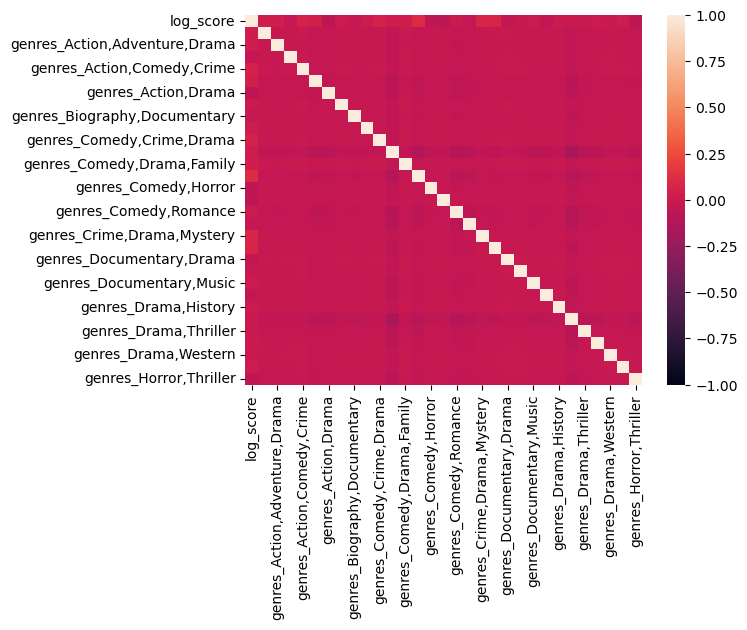

In [174]:
sns.heatmap(corr_matrix, vmin=-1, vmax=1 )
plt.show()

In [175]:
df_film_stats = df_films.iloc[:, :9]
df_film_stats.head()

,averageRating,numVotes,log_score,pocet_prekladov,primaryTitle,isAdult,startYear,runtimeMinutes,year_diff
index,,,,,,,,,
tt0000009,5.3,207,28.263410,4,Miss Jerry,0,1894.0,45.0,130.0
tt0000147,5.3,489,32.819521,2,The Corbett-Fitzsimmons Fight,0,1897.0,100.0,127.0
tt0000502,4.1,15,11.103006,1,Bohemios,0,1905.0,100.0,119.0
tt0000574,6.0,862,40.555532,8,The Story of the Kelly Gang,0,1906.0,70.0,118.0
tt0000591,5.0,21,15.222612,2,The Prodigal Son,0,1907.0,90.0,117.0


In [176]:
# Correlation Matrix
corr_matrix = df_film_stats.corr(numeric_only = True)
corr_matrix

,averageRating,numVotes,log_score,pocet_prekladov,isAdult,startYear,runtimeMinutes,year_diff
averageRating,1.000000,0.062484,0.331690,-0.003536,-0.060505,0.060238,0.009288,-0.060238
numVotes,0.062484,1.000000,0.384120,0.463379,-0.012464,0.030535,0.017080,-0.030535
log_score,0.331690,0.384120,1.000000,0.727591,-0.076399,0.054961,0.047891,-0.054961
pocet_prekladov,-0.003536,0.463379,0.727591,1.000000,-0.046761,-0.065837,0.029955,0.065837
isAdult,-0.060505,-0.012464,-0.076399,-0.046761,1.000000,-0.061814,-0.015215,0.061814
startYear,0.060238,0.030535,0.054961,-0.065837,-0.061814,1.000000,0.019390,-1.000000
runtimeMinutes,0.009288,0.017080,0.047891,0.029955,-0.015215,0.019390,1.000000,-0.019390
year_diff,-0.060238,-0.030535,-0.054961,0.065837,0.061814,-1.000000,-0.019390,1.000000


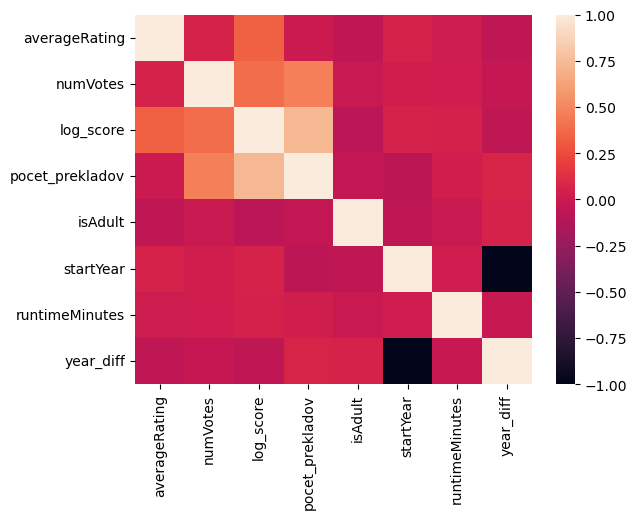

In [177]:
sns.heatmap(corr_matrix, vmin=-1, vmax=1 )
plt.show()

In [82]:
# Pair Plot
sns.pairplot(df_films)
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001590C423EC0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000015A56A43BA0> (for post_execute):


KeyboardInterrupt: 

       averageRating      numVotes
count   1.384950e+06  1.384950e+06
mean    6.957738e+00  1.037081e+03
std     1.384095e+00  1.760695e+04
min     1.000000e+00  5.000000e+00
25%     6.200000e+00  1.100000e+01
50%     7.200000e+00  2.600000e+01
75%     7.900000e+00  1.010000e+02
max     1.000000e+01  2.834920e+06
tconst           0
averageRating    0
numVotes         0
dtype: int64


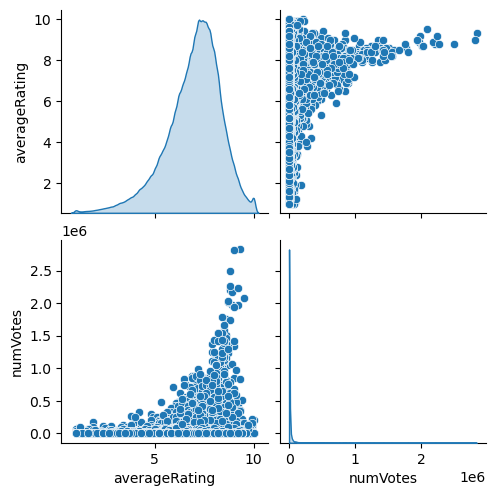

In [3]:
# Basic EDA
print(df.describe())  # Summary statistics
print(df.isnull().sum())  # Check for missing values

# Visualization example
sns.pairplot(df, diag_kind='kde')  # 's' controls the marker size
plt.show()

In [4]:
#df = df.drop(columns=['tconst'])
print(df)

            tconst  averageRating  numVotes
0        tt0000001            5.7      2014
1        tt0000002            5.7       272
2        tt0000003            6.5      1935
3        tt0000004            5.4       179
4        tt0000005            6.2      2706
...            ...            ...       ...
1384945  tt9916730            7.6        11
1384946  tt9916766            7.1        23
1384947  tt9916778            7.2        36
1384948  tt9916840            8.8         6
1384949  tt9916880            8.2         6

[1384950 rows x 3 columns]


In [9]:
# Connect to SQLite database
conn = sqlite3.connect('films.db')

# Querying the database
query = "SELECT * FROM title_akas"
counts = pd.read_sql_query(query, conn)

# Calculate the counts
counts = counts.groupby('titleId').size().reset_index(name='count')

query = "SELECT * FROM title_akas WHERE isOriginalTitle = 1"
title_akas = pd.read_sql_query(query, conn) 

# Merge the count back into the original DataFrame
title_akas = title_akas.merge(counts, on='titleId', how='left')

# Close the connection
conn.close()

title_akas.head()

MemoryError: 

In [4]:
print(title_akas.describe())  # Summary statistics
print(title_akas.isnull().sum())  # Check for missing values

           ordering
count  1.835447e+06
mean   2.217259e+00
std    2.933326e+00
min    1.000000e+00
25%    1.000000e+00
50%    2.000000e+00
75%    2.000000e+00
max    1.760000e+02
titleId            0
ordering           0
title              2
region             0
language           0
types              0
attributes         0
isOriginalTitle    0
dtype: int64


In [5]:
# Connect to SQLite database
conn = sqlite3.connect('films.db')

query = "SELECT titleid, COUNT(CASE WHEN isOriginalTitle = 0 THEN 1 END) AS pocet_prekladov FROM title_akas GROUP BY titleid"
title_akas = pd.read_sql_query(query, conn) 

# Close the connection
conn.close()

title_akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [14]:
# Connect to SQLite database
conn = sqlite3.connect('films.db')

query = "SELECT * FROM title_basics WHERE titleType = 'movie'"
title_ratings = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

title_ratings

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
...,...,...,...,...,...,...,...,...,...
667116,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
667117,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
667118,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
667119,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama


In [15]:
conn = sqlite3.connect('films.db')

query = "SELECT * FROM name_basics"
name_basics = pd.read_sql_query(query, conn)
conn.close()

name_basics

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0031983,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0075213"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0077975,tt0072562,tt0080455"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050986,tt0069467,tt0050976"
...,...,...,...,...,...,...
13133608,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt2455546,tt11657662,tt14069590"
13133609,nm9993716,Essias Loberg,\N,\N,None,\N
13133610,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13133611,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744
